# Using word embedding for movies recommendation

As part of OpenClassrooms last project in the Data Scientist program, I aim to improve the outcome of the second project of this very program : bulding a movie recommender system based on content only (no reviews, no users).

This is content-based recommendation, which is not the most popular field of recommendation. My first and rough approach lead to recommendations based on gross revenu or director's name, which was far from what I was looking for : recommendations based on movies genres or keywords.

As a matter of fact, with one-hot encoding only the genres and keywords, our classical, nearest-neighbors seeking unsupervised algorithm output recommendations quite appropriate about movies genres. However this simple model does not seem to have any clues about making sens out of keywords to bring movies together.

Therefore this kernel intends to use the work of Will Koehrsen for wikipedia books to build a movie recommender system based on word embedding.

- Reference article : https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526
- Reference kernel : https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/notebooks/Book%20Recommendation%20System.ipynb

Our dataset is quite small (50k entries before cleaning) and this must be kept in mind. The whole dataset can only be gathered using an API like the one provided by www.themoviedb.org (https://www.themoviedb.org/documentation/api) where the data are from, but this is a long and tidious process even with automatic tools.

## Kernel plan :

- 1)  Importations and functions
- 2)  Data loading 
- 3)  Data first observation
- 4)  Missing values
- 5)  Feature engineering
- 6)  Supervised learning issue : is a keyword in a specificc movie's keywords ?
- 7)  Neural network
- 8)  Visualisations
- 9)  Testing plan
- 10) Studying recommendations from embedding and nearest neighbors methods

# 1) Importations and functions

In [1]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
import random
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn import preprocessing, decomposition, manifold, cluster
import pickle
from matplotlib.patches import Patch
import matplotlib as mpl
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def dynamic_std_print(string_to_print):
    """
    Printing string on standard output and refreshing output line
    """
    sys.stdout.write('\r')
    sys.stdout.write(string_to_print)
    sys.stdout.flush()

In [3]:
def extract_text(df):
    """
    Take genres and keywords from main dataframe and output list regrouping those
    """
    # Convert to lower case
    genres = df.genres.lower()
    kw = df.keywords.lower()
    return genres.split(',') + kw.split(',')

In [4]:
def switch_term(terms_list, old_term, new_term):
    for i in range(len(terms_list)):
        terms_list[i] = terms_list[i].replace(old_term, new_term)
    return terms_list

In [5]:
def assign_genres(row, genre_column) :
    """
    Short routine to populate the rows of the genre DF
    """
    genre_found = 0
    string_genres = row.loc['genres'].lower()
    genres_list = string_genres.split(",")
    if genre_column in genres_list :
        genre_found = 1
    return genre_found

In [6]:
def isgenre(row, genre):
    isgenre = False
    if genre in row.genres_list:
        isgenre = True
    elif genre in row.kw_list:
        isgenre = True
    if isgenre:
        out = 1
    else:
        out = 0
    return out

In [7]:
def generate_batch(pairs, n_positive=50, negative_ratio=1.0, classification=False):
    """
    Generate batches of samples for training
    """
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Get pairs set
    pairs_set = set(pairs)

    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (movie_id, kw_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (movie_id, kw_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_movie = random.randrange(genres_kw_df.shape[0])
            random_kw = random.randrange(len(unique_keywords))
            
            # Check to make sure this is not a positive example
            if (random_movie, random_kw) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_movie, random_kw, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'movie': batch[:, 0], 'kw': batch[:, 1]}, batch[:, 2]

In [8]:
def movies_embedding_model(movies_shape, kw_shape, embedding_size=50, classification=False):
    """
    Model to embed books and wikilinks using the functional API.
    Trained to discern if a movie is of a particular genre
    """
    
    # Both inputs are 1-dimensional
    movie = Input(name = 'movie', shape = [1])
    kw = Input(name = 'kw', shape = [1])
    
    # Embedding the movies (shape will be (None, 1, 50))
    movie_embedding = Embedding(name = 'movie_embedding',
                                 input_dim = movies_shape,
                                 output_dim = embedding_size)(movie)
    
    
    # Embedding the keywords (shape will be (None, 1, 50))
    kw_embedding = Embedding(name = 'kw_embedding',
                            input_dim = kw_shape,
                            output_dim = embedding_size)(kw)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([movie_embedding, kw_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [movie, kw], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [movie, kw], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

In [9]:
def train_embedding(pairs, shape_movies, shape_kw, n_positive=1000, emb_size=50, verb=1):
    """
    Train neural network
    """
    # Instantiate model and show parameters
    model = movies_embedding_model(shape_movies, shape_kw, emb_size)
 
    # Generate batch
    gen = generate_batch(pairs, n_positive, negative_ratio=2, classification=True)

    # Train
    h = model.fit_generator(gen, epochs=10, 
                            steps_per_epoch=len(pairs) // n_positive,
                            verbose=verb)
    return h, model

In [10]:
def extract_embedding(layer, selection_id):
    """
    Output trained weights from embedding layer and use it to get closest recommendations
    """
    # Extract embeddings
    weights = layer.get_weights()[0]
    # Normalize weights
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    # Calculate dot product between movie and all others
    dists = np.dot(weights, weights[selection_id])
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    # Take the last n sorted distances
    closest = sorted_dists[-11:]
    closest = [x for x in reversed(closest)]
    return closest, weights

In [11]:
def recom_genres(ref_genres, recommendation_df):
    """
    bar plot of genre in recommendations
    """
    list_genres = ref_genres.split(',')
    genres_recom = pd.Series(",".join(recommendation_df.genres.values.tolist()).split(",")).value_counts()
    # Gather all genres (ref and recom)
    all_genres = set(list_genres + genres_recom.index.values.tolist())
    # Get other genres
    other_genres = all_genres - set(list_genres)
    # Create serie for bar plot
    genres_bar_df = pd.Series(0, index=[list_genres + list(other_genres)])
    # Fill bar plot
    for genre in genres_recom.index:
        genres_bar_df.loc[genre] = genres_recom.loc[genre]
    return genres_bar_df

In [12]:
def recom_kw(ref_kw, recommendation_df):
    """
    Histogram of keywords in recommendations
    """
    list_kw = ref_kw.split(',')
    kw_recom = pd.Series(",".join(recommendation_df.keywords.values.tolist()).split(",")).value_counts()
    # Gather all kw (ref and recom)
    all_kw = set(list_kw + kw_recom.index.values.tolist())
    # Get other kw
    other_kw = all_kw - set(list_kw)
    # Create serie for histogram
    kw_histo_df = pd.Series(0, index=[list_kw + list(other_kw)])
    # Fill histogram
    for kw in kw_recom.index:
        kw_histo_df.loc[kw] = kw_recom.loc[kw]
    return kw_histo_df

In [13]:
# get a color map
my_cmap = cm.get_cmap('jet')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=12)
# some boring fake data
myblue = 3
myorange = 9
# get a color map with two different colors
cmap_2c = cm.get_cmap('bwr')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
norm_2c = Normalize(vmin=0, vmax=1)

In [14]:
def find_movie(string, movies_df):
    """
    Snippet of code to find movie based on its title. Find movie based on its title
    """
    return movies_df[movies_df['title'].str.lower().str.contains(string)]

In [170]:
def recommender_behaviour_study(input_df, main_df):
    """
    Take a dataframe as input and output two plots and mean accuracy for genres and keywords for 10 predictions
    """
    genres_acc = []
    kw_acc = []
    for i in range(0, len(input_df)):
        dynamic_std_print('Movie %i / %i' % (i+1, len(input_df)))
        # Movie id
        temp_movie_id = input_df.iloc[i].name
        # Extract weights
        recom_movie, movies_weights = extract_embedding(layer, temp_movie_id)
        # Get recommendations (closest movies)
        recom_df = main_df.loc[recom_movie[1:], ['title', 'genres', 'keywords']]
        # Get recommendations genres
        genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
        # Count genres of selected movie
        n_genres = len(main_df.loc[temp_movie_id, :].genres_list)
        # Process recommendation genres
        genres_recommendation = recom_genres(main_df.loc[temp_movie_id, :].genres, recom_df)
        # Compute genres accuracy for recommendations
        genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
        genres_acc.append(genres_accuracy)
        # Count kw of selected movie
        n_kw = len(main_df.loc[temp_movie_id, :].kw_list)
        # Process recommendation keywords
        keywords_recommendation = recom_kw(main_df.loc[temp_movie_id, :].keywords, recom_df)
        # Compute kw accuracy for recommendations
        kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
        kw_acc.append(kw_accuracy)
        
    # Genres plot
    fig, ax = plt.subplots()
    ax = sns.distplot(genres_acc, bins=100, kde=False)
    ax.set_xlabel("Recommendations genres accuracy", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title("Genres accuracy", fontsize=12)
    # Keywords plot
    fig, ax = plt.subplots()
    ax = sns.distplot(kw_acc, bins=100, kde=False)
    ax.set_xlabel("Recommendations keywords accuracy", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title("Keywords accuracy", fontsize=12)
    print('\n')
    print('Genres accuracy : {:.2f}'.format(mean(genres_acc)))
    print('Keywords accuracy : {:.2f}'.format(mean(kw_acc)))
    
    return mean(genres_acc), mean(kw_acc)

In [15]:
def recom_genres_study(ref, recom):
    # get a color map
    my_cmap = cm.get_cmap('jet')
    # get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=0, vmax=12)
    # some boring fake data
    myblue = 3
    myorange = 9
    # Count genres of selected movie
    n_genres = len(ref.genres_list)
    # Process recommendation genres
    genres_recommendation = recom_genres(ref.genres, recom)
    # Define vector for colors
    my_data = [myblue]*n_genres + (genres_recommendation.shape[0] - n_genres)*[myorange]
    # Plot bar plot
    genres_recommendation.plot.barh(color=my_cmap(my_norm(my_data)), fontsize=12)
    # Get axes for graph tuning
    ax = plt.gca()
    # Set legend elements
    legend_elements = [Patch(facecolor=my_cmap(my_norm([3]))[0], label='ref genres'),
                       Patch(facecolor=my_cmap(my_norm([9]))[0], label='other genres')]
    # Create handmade legend
    ax.legend(handles=legend_elements)
    # Set axis labels and title
    ax.set_xlabel("Frequency in recommendations", fontsize=12)
    ax.set_ylabel("Genres", fontsize=12)
    ax.set_title("Genres in 5 first recommendations", fontsize=12);
    # Compute genres accuracy for recommendations
    genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
    print('Genres accuracy : {:.2f}'.format(genres_accuracy))

In [16]:
def recom_kw_study(ref, recom):
    # get a color map
    my_cmap = cm.get_cmap('jet')
    # get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=0, vmax=12)
    # some boring fake data
    myblue = 3
    myorange = 9
    # Count kw of selected movie
    n_kw = len(ref.kw_list)
    # Process recomendation keywords
    keywords_recommendation = recom_kw(ref.keywords, recom)
    # Define vector for colors
    my_data = [myblue]*n_kw + (keywords_recommendation.shape[0] - n_kw)*[myorange]
    # Plot
    # First plot : movie's keywords histogram
    fig, ax = plt.subplots()
    ax = keywords_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(keywords_recommendation.unique()))
    # Set axis labels and title
    ax.set_xlabel("Frequency in recommendations", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.set_title("Keywords in 10 first recommendations", fontsize=12)
    # pyplot.locator_params(axis='x', nbins=3)
    # Second plot : movie's keywords frequency
    fig, ax = plt.subplots()
    # Movie's keywords for barplot
    movie_kw = keywords_recommendation.loc[ref.kw_list]
    ax = movie_kw.plot.barh(fontsize=12)
    # Set axis labels and title
    ax.set_xlabel("Keywords frequency in recommendation", fontsize=12)
    ax.set_ylabel("Movie's keywords", fontsize=12)
    ax.set_title("Movie's keywords in 10 first recommendations", fontsize=12);
    # Compute kw accuracy for recommendations
    kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
    print('Keywords accuracy : {:.2f}'.format(kw_accuracy))

# 2) Data loading

In [17]:
# Getting current path
path = os.getcwd()
file = '/data/movie_metadata_large.csv'

# Verifying data presence
try :
    data_raw = pd.read_csv(path + file, sep=',')
except FileNotFoundError :
    print("Please check if the file %s is in the 'data' folder at the current location" % file)

# 3) Data first observation

In [18]:
data_raw.shape

(53705, 4)

Not to big of a dataset, what's in it ?

In [19]:
data_raw.head()

title  \
0                                 Batman & Robin   
1  About the Looking for and the Finding of Love   
2             The Life Aquatic with Steve Zissou   
3                                             8½   
4                                    The Pianist   

                                                cast  \
0  George Clooney,Chris O'Donnell,Arnold Schwarze...   
1  Moritz Bleibtreu,Alexandra Maria Lara,Uwe Ochs...   
2  Bill Murray,Anjelica Huston,Cate Blanchett,Wil...   
3  Marcello Mastroianni,Claudia Cardinale,Anouk A...   
4  Adrien Brody,Thomas Kretschmann,Frank Finlay,M...   

                                  genres  \
0  Science Fiction,Action,Fantasy,Comedy   
1                           Comedy,Drama   
2                 Adventure,Comedy,Drama   
3                          Fantasy,Drama   
4                              Drama,War   

                                            keywords  
0  double life,dc comics,dual identity,crime figh...  
1  berlin germany,suicide,lovesickness,greece,com...  
2  parent child relationship,red cap,rivalry,dysf...  
3  individual,scapegoat,adultery,screenplay,cinec...  
4  resistance,holocaust,hunger,world war ii,priso...

Obvious duplicates ?

In [20]:
data_raw[data_raw.duplicated()].shape

(12, 4)

Drop obvious duplicates if any

In [21]:
data_raw = data_raw.drop_duplicates(keep='first')
data_raw.shape

(53693, 4)

Movies duplicates ?

In [22]:
dup = data_raw[data_raw.duplicated(subset=["title"])]
n_dup = dup.shape[0]
print("%i duplicates sharing movie title" % n_dup)
print(dup.title.head(10))

2825 duplicates sharing movie title
49                       Shaft
303                    The Fog
311          Annaluise & Anton
318                   The Omen
383         Planet of the Apes
424    The Thomas Crown Affair
434           Dawn of the Dead
524         The Miracle Worker
640    Blood: The Last Vampire
753                      Crash
Name: title, dtype: object


Duplicates are most likely remakes

In [23]:
data_raw[data_raw.title == "The Thomas Crown Affair"]

title  \
423  The Thomas Crown Affair   
424  The Thomas Crown Affair   

                                                  cast  \
423  Steve McQueen,Faye Dunaway,Paul Burke,Jack Wes...   
424  Pierce Brosnan,Rene Russo,Denis Leary,Ben Gazz...   

                           genres  \
423  Romance,Crime,Thriller,Drama   
424           Drama,Crime,Romance   

                                              keywords  
423  in love with enemy,hold-up robbery,boredom,ins...  
424  martinique,claude monet,famous painting,glider...

# 4) Missing values

In [24]:
data_raw.isna().sum()

title           0
cast         5271
genres       5496
keywords    21723
dtype: int64

Remove rows with missing values

In [25]:
data_raw = data_raw.dropna()
data_raw.shape

(29819, 4)

In [26]:
data_raw.isna().sum()

title       0
cast        0
genres      0
keywords    0
dtype: int64

# 5) Feature Engineering

In [27]:
data_raw.head(1)

title                                               cast  \
0  Batman & Robin  George Clooney,Chris O'Donnell,Arnold Schwarze...   

                                  genres  \
0  Science Fiction,Action,Fantasy,Comedy   

                                            keywords  
0  double life,dc comics,dual identity,crime figh...

Pass genres to lowercase

In [28]:
data_raw.loc[:, 'genres'] = data_raw.genres.apply(lambda x: x.lower())

In [29]:
data_raw.loc[:, 'text'] = data_raw.apply(extract_text, axis=1)

In [30]:
data_raw.head(1)

title                                               cast  \
0  Batman & Robin  George Clooney,Chris O'Donnell,Arnold Schwarze...   

                                  genres  \
0  science fiction,action,fantasy,comedy   

                                            keywords  \
0  double life,dc comics,dual identity,crime figh...   

                                                text  
0  [science fiction, action, fantasy, comedy, dou...

In [31]:
# Filter out stop words
stop_words = set(stopwords.words('english'))

In [32]:
# Modifying the genres as well
data_raw.loc[:, 'genres'] = data_raw.loc[:, 'genres'].apply(lambda x: x.replace('science fiction', 'scifi'))

In [33]:
# Get splitted genres in a serie
s = data_raw.genres.str.lower().str.split(",").values.tolist()
# Get unique genres
unique_genres = [genres_out for genres_in in s for genres_out in genres_in]
unique_genres = set(unique_genres)
unique_genres = list(unique_genres)
print("%i genres in the dataset" % len(unique_genres))

19 genres in the dataset


In [34]:
# Get splitted keywords in a serie
s = data_raw.keywords.str.lower().str.split(",").values.tolist()
# Get unique keywords
keywords = [keywords_out for keywords_in in s for keywords_out in keywords_in]
# Remove stopwords
stop_words = set(stopwords.words('english'))
keywords_tokens_sw = [w for w in keywords if not w in stop_words]
set_keywords = set(keywords_tokens_sw)
unique_keywords = list(set_keywords)
print("%i keywords in the dataset" % len(unique_keywords))
kw_index = {kw: idx for idx, kw in enumerate(unique_keywords)}

17624 keywords in the dataset


Create new dataframe

In [35]:
genres_kw_df = data_raw.loc[:, ['title', 'genres', 'keywords']]
genres_kw_df = genres_kw_df.reset_index(drop=True)
genres_kw_df.head(1)

title                       genres  \
0  Batman & Robin  scifi,action,fantasy,comedy   

                                            keywords  
0  double life,dc comics,dual identity,crime figh...

In [36]:
# Take strings and output list of tokens in lower case
genres_kw_df.loc[:, 'genres_list'] = genres_kw_df.genres.apply(lambda x: x.lower().split(","))
genres_kw_df.loc[:, 'kw_list'] = genres_kw_df.keywords.apply(lambda x: x.lower().split(","))

In [37]:
# Beware of sci-fi
genres_kw_df.loc[:, 'genres_list'] = genres_kw_df.genres_list.apply(switch_term, args=('sci-fi', ('scifi')))
genres_kw_df.loc[:, 'kw_list'] = genres_kw_df.kw_list.apply(switch_term, args=('sci fi', ('scifi')))

In [38]:
# 
genres_kw_df.loc[:, 'genres_str'] = genres_kw_df.genres_list.apply(lambda x: " ".join([w for w in " ".join(x).split() if not w in stop_words]))
genres_kw_df.loc[:, 'kw_str'] = genres_kw_df.kw_list.apply(lambda x: " ".join([w for w in " ".join(x).split() if not w in stop_words]))

In [39]:
genres_kw_df.head(3)

title                       genres  \
0                                 Batman & Robin  scifi,action,fantasy,comedy   
1  About the Looking for and the Finding of Love                 comedy,drama   
2             The Life Aquatic with Steve Zissou       adventure,comedy,drama   

                                            keywords  \
0  double life,dc comics,dual identity,crime figh...   
1  berlin germany,suicide,lovesickness,greece,com...   
2  parent child relationship,red cap,rivalry,dysf...   

                        genres_list  \
0  [scifi, action, fantasy, comedy]   
1                   [comedy, drama]   
2        [adventure, comedy, drama]   

                                             kw_list  \
0  [double life, dc comics, dual identity, crime ...   
1  [berlin germany, suicide, lovesickness, greece...   
2  [parent child relationship, red cap, rivalry, ...   

                    genres_str  \
0  scifi action fantasy comedy   
1                 comedy drama   
2       adventure comedy drama   

                                              kw_str  
0  double life dc comics dual identity crime figh...  
1  berlin germany suicide lovesickness greece com...  
2  parent child relationship red cap rivalry dysf...

# 6) Supervised learning issue : is a keyword in a specificc movie's keywords ?

In [40]:
genres_kw_df.head(1)

title                       genres  \
0  Batman & Robin  scifi,action,fantasy,comedy   

                                            keywords  \
0  double life,dc comics,dual identity,crime figh...   

                        genres_list  \
0  [scifi, action, fantasy, comedy]   

                                             kw_list  \
0  [double life, dc comics, dual identity, crime ...   

                    genres_str  \
0  scifi action fantasy comedy   

                                              kw_str  
0  double life dc comics dual identity crime figh...

### Building pairs for supervised training : is a specific keyword in the movies keywords ?

In [41]:
pairs = []

# Iterate through each movie
for i in range(0, genres_kw_df.shape[0]):
    dynamic_std_print('Movie %i / %i' % (i, genres_kw_df.shape[0]))
    # Iterate through the keywords of the movies
    pairs.extend((i, kw_index[kw]) for kw in genres_kw_df.iloc[i,:].kw_list if kw in unique_keywords)

Movie 29818 / 29819

In [42]:
print('We have less than %i positives examples' % (ceil(len(pairs) / 10000) * 10000))

We have less than 150000 positives examples


Test batch-generating function

In [43]:
next(generate_batch(pairs, n_positive=2, negative_ratio=2))

({'movie': array([ 7153., 14085., 22322., 28176., 13155., 22735.]),
  'kw': array([15043., 12026.,  3963.,  8591., 14636.,  9425.])},
 array([-1.,  1.,  1., -1., -1., -1.]))

Save input dataframe for easy loading and usage in hard code

In [44]:
# pickle.dump(genres_kw_df, open('data/input_df_embedding.pkl', 'wb'))

Save positive pairs for easy loading and usage in hard code

In [45]:
# pickle.dump(pairs, open('data/pairs_training.pkl', 'wb'))

# 7) Neural Network Model

Implement the neural network with two embedding layers :
- one for the movies titles
- one for the keywords

In [46]:
n_positive = 1000
history, emb_model = train_embedding(pairs, genres_kw_df.shape[0], len(unique_keywords), n_positive, emb_size=100)

Epoch 1/10
148/148 [==============================] - 26s 174ms/step - loss: 0.3025
Epoch 2/10
148/148 [==============================] - 25s 171ms/step - loss: 0.2232
Epoch 3/10
148/148 [==============================] - 25s 171ms/step - loss: 0.1710
Epoch 4/10
148/148 [==============================] - 25s 170ms/step - loss: 0.1234
Epoch 5/10
148/148 [==============================] - 25s 170ms/step - loss: 0.0865
Epoch 6/10
148/148 [==============================] - 25s 170ms/step - loss: 0.0824
Epoch 7/10
148/148 [==============================] - 25s 170ms/step - loss: 0.0713
Epoch 8/10
148/148 [==============================] - 25s 170ms/step - loss: 0.0732
Epoch 9/10
148/148 [==============================] - 25s 169ms/step - loss: 0.0660
Epoch 10/10
148/148 [==============================] - 25s 170ms/step - loss: 0.0659


As we see the model's loss to decrease as the epochs run, we may have hope that the model is learning somethin.

Let's point out that the supervised learning is what we are looking for here, not the classification outcome. The learning itself allows the model to actually learn and modify the embeddings layers weights, which are the coordinates of our words (titles or keywords) in their own vectorial 50 (or 100) - dimensional space.

In [47]:
# Select any movie for testing
movie_id = 0

In [48]:
# Get layer
layer = emb_model.get_layer('movie_embedding')
# Extract weights
recommendation, movies_weights = extract_embedding(layer, movie_id)
# Get recommendations (closest movies)
recom_df = genres_kw_df.loc[recommendation[1:], ['title', 'genres', 'keywords']]
# Display reference
display(genres_kw_df.loc[movie_id, ['title', 'genres', 'keywords']].to_frame())
# Display recommendation
display(recom_df)
# Get recommendations genres
genres_reco = pd.Series(",".join(recom_df.genres.values.tolist()).split(","))
# Count genres of selected movie
n_genres = len(genres_kw_df.loc[movie_id, :].genres_list)
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Compute genres accuracy for recommendations
genres_accuracy = genres_recommendation.iloc[:n_genres].sum() / genres_recommendation.sum()
print('Genres accuracy : {:.2f}'.format(genres_accuracy))
# Count kw of selected movie
n_kw = len(genres_kw_df.loc[movie_id, :].kw_list)
# Process recommendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Compute kw accuracy for recommendations
kw_accuracy = keywords_recommendation.iloc[:n_kw].sum() / keywords_recommendation.sum()
print('Keywords accuracy : {:.2f}'.format(kw_accuracy))

0
title                                        Batman & Robin
genres                          scifi,action,fantasy,comedy
keywords  double life,dc comics,dual identity,crime figh...

title  \
946                            Superman   
4383                    The Incredibles   
27428    Green Lantern: Emerald Knights   
4666                         Iron Man 2   
1422                             Batman   
18607        Batman: Under the Red Hood   
12636  The Trial of the Incredible Hulk   
12500                      Generation X   
22579                X-Men: First Class   
549                                TMNT   

                                       genres  \
946                   adventure,fantasy,scifi   
4383        action,adventure,animation,family   
27428  action,adventure,animation,scifi,drama   
4666                   adventure,action,scifi   
1422      family,adventure,comedy,scifi,crime   
18607                action,animation,mystery   
12636    adventure,fantasy,drama,action,scifi   
12500           tv movie,action,fantasy,scifi   
22579                  action,scifi,adventure   
549         adventure,animation,comedy,family   

                                                keywords  
946    saving the world,journalist,dc comics,crime fi...  
4383   secret identity,secret,hero,island,wretch,weap...  
27428  dc comics,superhero,based on comic,super power...  
4666   usa,technology,malibu,superhero,based on comic...  
1422   submarine,dc comics,missile,shark attack,rescu...  
18607  martial arts,dc comics,fictional place,vigilan...  
12636  dual identity,crime fighter,witness,transforma...  
12500  mutant,superhero,based on comic,teenager,super...  
22579  cia,nuclear war,mutant,mine,superhero,based on...  
549    new york,sibling relationship,journalist,marti...

Genres accuracy : 0.49
Keywords accuracy : 0.22


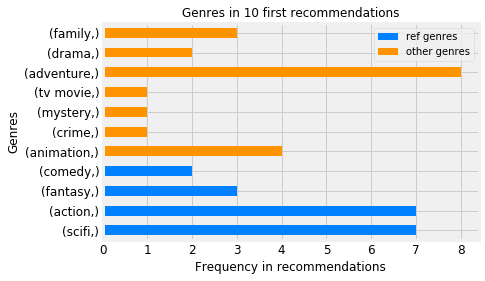

In [49]:
# Process recommendation genres
genres_recommendation = recom_genres(genres_kw_df.loc[movie_id, :].genres, recom_df)
# Define vector for colors
my_data = [myblue]*n_genres + (genres_recommendation.shape[0] - n_genres)*[myorange]
# Plot bar plot
genres_recommendation.plot.barh(color=my_cmap(my_norm(my_data)), fontsize=12)
# Get axes for graph tuning
ax = plt.gca()
# Set legend elements
legend_elements = [Patch(facecolor=my_cmap(my_norm([3]))[0], label='ref genres'),
                   Patch(facecolor=my_cmap(my_norm([9]))[0], label='other genres')]
# Create handmade legend
ax.legend(handles=legend_elements)
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Genres", fontsize=12)
ax.set_title("Genres in 10 first recommendations", fontsize=12);

The blue genres are the genres of the reference movie (here 'Batman & Robin'). The more those genres are represented in the recommendations, the more close to the reference movie's genres the recommendations are.

Another genre well represented in the recommendation here is adventure, which is quite appropriate as well for our reference movie.

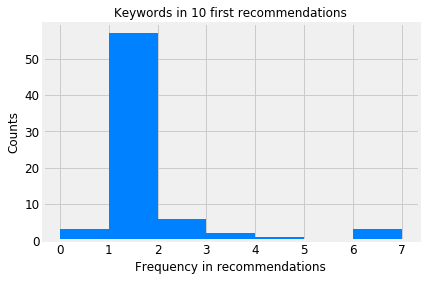

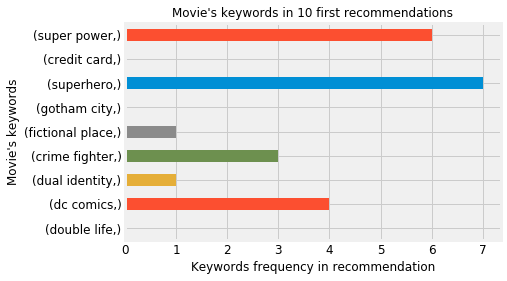

In [50]:
# Process recomendation keywords
keywords_recommendation = recom_kw(genres_kw_df.loc[movie_id, :].keywords, recom_df)
# Define vector for colors
my_data = [myblue]*n_kw + (keywords_recommendation.shape[0] - n_kw)*[myorange]

# Plot
# First plot : movie's keywords histogram
fig, ax = plt.subplots()
ax = keywords_recommendation.plot.hist(color=my_cmap(my_norm(my_data)), fontsize=12, bins=len(keywords_recommendation.unique()))
# Set axis labels and title
ax.set_xlabel("Frequency in recommendations", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Keywords in 10 first recommendations", fontsize=12)
# pyplot.locator_params(axis='x', nbins=3)

# Second plot : movie's keywords frequency
fig, ax = plt.subplots()
# Movie's keywords for barplot
movie_kw = keywords_recommendation.loc[genres_kw_df.loc[movie_id, :].kw_list]
ax = movie_kw.plot.barh(fontsize=12)
# Set axis labels and title
ax.set_xlabel("Keywords frequency in recommendation", fontsize=12)
ax.set_ylabel("Movie's keywords", fontsize=12)
ax.set_title("Movie's keywords in 10 first recommendations", fontsize=12);

The first plot shows that among the numerous keywords associated with our 10 recommendations movies, most are only appearing once. HOWEVER, the second plot shows the keywords associated to our reference movie, and how many times those came out of the recommendations.

The more frequent keywords are in the second plot, the closer recommendations movies keywords are to the reference movie keywords.

Here we can see that the model came out with super power or superhero movies, but also with dc-comics movies (and not marvel movies for instance) wich is really interesting behaviour.

# 8) Visualisations

We will try to look at the embedding space of our movies titles, in order to make (hopefully) gatherings. For this task we will use TSNE manifold algorithm, projected on the 2 principal components of our embedded space in order to be able to visualize the space.

TSNE

In [51]:
tsne_test = manifold.TSNE(n_components=2, perplexity=50, n_iter=1000, metric='cosine').fit_transform(movies_weights)

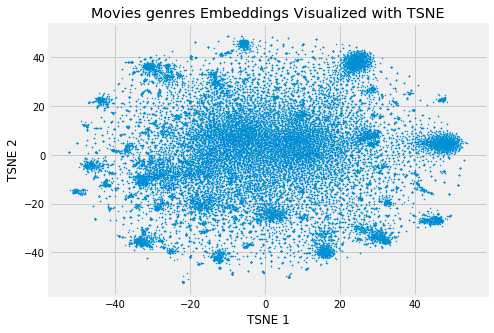

In [52]:
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

At first glence once can see many clusters, but let's be careful before jumping to conclusions with TSNE outputs which are known to be as magical as difficult to master.

#### KMEANS clustering on movies weights

Clustering helps us emphasize clusters and then look for sense in those

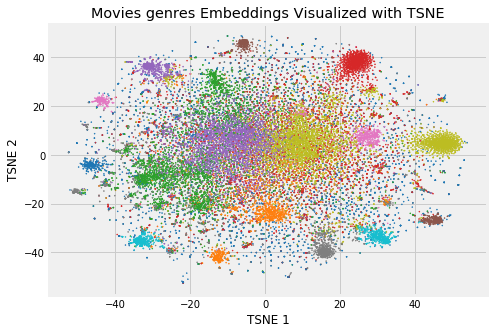

In [53]:
kmeans = cluster.KMeans(n_clusters=20)
kmeans = kmeans.fit(movies_weights)
categs_kmeans = kmeans.predict(movies_weights)
plt.figure(figsize = (7, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=categs_kmeans, s=1,cmap=plt.cm.tab10)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the SOUTH cluster

In [54]:
ids_south_cluster = np.where((tsne_test[:, 0] < 20) & (tsne_test[:, 0] > 5) & (tsne_test[:, 1] < -40))[0]
genres_kw_df.loc[ids_south_cluster, ['title', 'genres', 'keywords']]

title  \
1209           Bob Dylan - TV Live & Rear 1963 - 1975   
2903                                Schlag auf Schlag   
2954                         Übermut im Salzkammergut   
2976                                    Vaya con Dios   
2989                                   Die Geierwally   
3207                              Christmas in Boston   
4592                             The Three Musketeers   
5401                                        Farinelli   
7138                                    The Music Man   
7311                                 Dil To Pagal Hai   
7543                          Beverly Hills Chihuahua   
7730                                 The Goodbye Girl   
8064                                         Car Wash   
8169        Céline Dion: Opening Night Live Las Vegas   
8273                                     Room Service   
8280                             The Three Caballeros   
8368                                   Forbidden Zone   
8447                                         Festival   
8467                                        Saawariya   
8477                                    The Loved One   
8587                                       Rhinestone   
8671                         G:MT Greenwich Mean Time   
8947                               Surviving the Game   
9042                                      San Antonio   
9046                                   A Song Is Born   
9063                                   Anchors Aweigh   
9144                                            Duets   
9480                              Bells of San Angelo   
9596                   Pearl Jam: Single Video Theory   
9714                                          BoyTown   
...                                               ...   
27730  Charlie Chan and the Curse of the Dragon Queen   
27767                                    Emerald City   
27836                                   Three Waltzes   
27861                                Romashkin Effect   
27987                               La Belle meunière   
28009                                          Carmen   
28042                                      The Bandit   
28087                              The Haunted Castle   
28320                              Tristan und Isolde   
28353                   The Ring Cycle: Das Rheingold   
28357                       The Ring Cycle: Siegfried   
28359                 The Ring Cycle: Gotterdammerung   
28360                                   Das Rheingold   
28379                      Scorpions: World Wide Live   
28419                       Celeste... no es un color   
28457                                    Coney Island   
28554                                           Dhill   
28624     The Man from Snowy River: Arena Spectacular   
28872            Jaco Pastorius - Live and Outrageous   
28874              Michael Flatley: Lord of the Dance   
28884                                 Do Not Leave...   
28923                                 Bells of Autumn   
28989                  Nutcracker: The Motion Picture   
28993                                 Sertão em Festa   
29010                                  La Cenerentola   
29208                            And the Spring Comes   
29428                  Mega Mindy en de Poppenmeester   
29470                                          Rebels   
29727                                        Big Beat   
29753                Bulldog Drummond's Secret Police   

                                     genres  \
1209                            documentary   
2903                                 comedy   
2954                     music,comedy,drama   
2976                                 comedy   
2989                                 comedy   
3207                   comedy,drama,romance   
4592                action,adventure,comedy   
5401                          history,drama   
7138                    comedy,music,family   
7311                   drama,romance,comedy

Looks like sport-related movies to me !

Now check our hypothesis : let's identify the sport movies

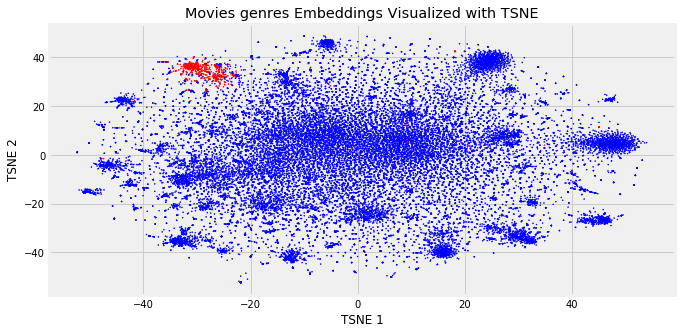

In [55]:
# Build a test vector for the 'sport' keyword
test_sport = genres_kw_df.apply(isgenre, args=('sport',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_sport.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the WEST cluster

In [56]:
ids_west_cluster = np.where((tsne_test[:, 0] < -30) & (tsne_test[:, 1] > -50) & (tsne_test[:, 1] < -15))[0]
genres_kw_df.loc[ids_west_cluster, ['title', 'genres', 'keywords']]

title  \
749                           Bill & Ted's Bogus Journey   
769                                             Godzilla   
770                                 Godzilla Raids Again   
771                               King Kong vs. Godzilla   
772                                  Mothra vs. Godzilla   
931                                     Inherit the Wind   
1082                                      Romeo Must Die   
1125                                    The Time Machine   
1144                                       Lost in Space   
1338                                          The Choice   
1415                                   Aces Go Places II   
1508                                             Scherzo   
1604                                    End of the World   
1668                                Destroy All Monsters   
1675                          Ebirah, Horror of the Deep   
1791                                  Drums of Fu Manchu   
1851                                          Clockmaker   
1888   All the Brothers of the West Support Their Father   
1901                                  Destination Saturn   
1992                                     The Scary Movie   
2139                                   Der Fall Rohrbach   
2280                                Je T'Aime, Je T'Aime   
2553             Battlefield Earth: Evolution & Creation   
2569                                     Finders Killers   
2764   The World is Big and Salvation Lurks Around th...   
3032                                        The Marksman   
3033                                          Navajo Joe   
3088                       Godzilla vs. Mechagodzilla II   
3091                                               Keoma   
3236                        Futurama: Bender's Big Score   
...                                                  ...   
29025                                    Future War 1986   
29136          Adventures in Odyssey: Go West Young Man!   
29151                                      Life with Tom   
29175                                  The Magic Serpent   
29194                     Winnie the Pooh and Tigger Too   
29312                           Steamboat Round the Bend   
29319                                       The Old Mill   
29323                                     Little Quacker   
29339             Adventures in Odyssey: A Twist In Time   
29406                                      George & A.J.   
29429                                        Rub and Tug   
29452                                      Love That Pup   
29477                                 Bleach: Hell Verse   
29532                            For a Few Extra Dollars   
29564                                             Melody   
29585                                  The Missing Mouse   
29587                                     Mouse For Sale   
29594                                     Eternal Family   
29595                                Girl from Phantasia   
29597                   Hotori - The Simple Wish for Joy   
29600                                      Johnny Hamlet   
29609                                       The Invaders   
29619                                    Cherry no Manma   
29632                                      The Ugly Ones   
29647                                        Thawing Out   
29680                                        Mucho Mouse   
29718                              Gantz: Perfect Answer   
29725                                     No Room To Die   
29748  Digimon Frontier - Revival of the Ancient Digimon   
29765                                              Pátio   

                                       genres  \
749      adventure,comedy,fantasy,scifi,music   
769                     thriller,horror,scifi   
770                       action,scifi,horror   
771                    action,adventure,scifi   
772            fantasy,scifi,action,adventure   
931                             dram

Looks like woman director movies to me !

Now check our hypothesis : let's identify the woman director movies

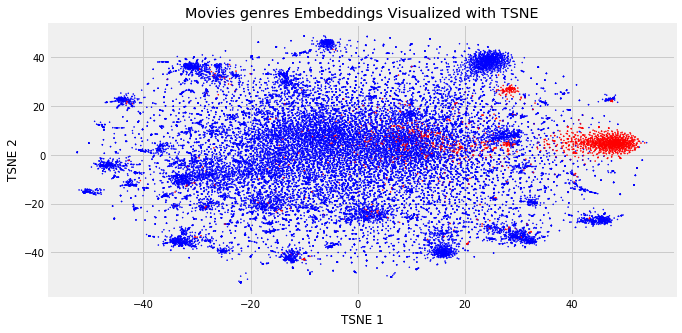

In [57]:
# Build a test vector for the 'woman director' keyword
test_woman_director = genres_kw_df.apply(isgenre, args=('woman director',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_woman_director.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the NORTH cluster

In [58]:
ids_north_cluster = np.where((tsne_test[:, 0] < 20) & (tsne_test[:, 0] > 10) & (tsne_test[:, 1] > 40))[0]
genres_kw_df.loc[ids_north_cluster, ['title', 'genres', 'keywords']]

title  \
555                                   Dogtown and Z-Boys   
582                                    Gleaming the Cube   
7328                                          The Hammer   
7531                                   Romanzo criminale   
7956                                        Fully Flared   
9193               Almost Round Three - The Almost Video   
9211                                            Berkeley   
9882                                  El Colombian Dream   
11079                                        Yeah Right!   
11387                                    The Puffy Chair   
11850                                        Saint Ralph   
12199                                          Deck Dogz   
12859                                   Beautiful Losers   
13053                               Here Comes the Groom   
15682                                 Murder in the Dark   
15684                                 Murder in Paradise   
15791                                        Funny Ha Ha   
17032                         The Passion of Darkly Noon   
17049                                       Boxboarders!   
17792                                            Madison   
17944                                              Cyrus   
18085                                  The Wind Journeys   
18149                           Escanaba in da Moonlight   
18159                  Jean Michel Jarre: Water for Life   
18547                          At the End of the Spectra   
18555                                           Time Out   
18690                                         King Cobra   
19117                                     Tennis Anyone?   
19197                       The Man Who Souled the World   
19239                                          Choose Me   
19701         Powell Peralta: The Search for Animal Chin   
19931                        Another Time, Another Place   
20453                                        Sky Bandits   
20560                          Our Lady of the Assassins   
22600                  The Miracle of Our Lady of Fatima   
22678                                      A Time to Die   
22868                                       Black Sunday   
23299                                       Chasing 3000   
24956                                      Machotaildrop   
25240                               411VM Presents : 911   
25845                                        Flip: Sorry   
25846                              Adio: One Step Beyond   
25849                                   Etnies: Restless   
26606                                             Bhutto   
27064                                      Finding Lenny   
27356                                Female on the Beach   
28513                           The Assassination Bureau   
29343  Rising Son: The Legend of Skateboarder Christi...   
29644                                 This Is My Element   

                                       genres  \
555                               documentary   
582                                    action   
7328                                   comedy   
7531                                    drama   
7956                              documentary   
9193                              documentary   
9211                                    drama   
9882                             comedy,drama   
11079                             documentary   
11387                    drama,comedy,romance   
11850                            comedy,drama   
12199                            drama,comedy   
12859                             documentary   
13053                    comedy,music,romance   
15682                                   crime   
15684                             crime,drama   
15791                            drama,comedy   
17032                  mystery,drama,thriller   
17049                                  comedy   
17792                  action,adventure,drama   
17944                

Looks like short movies to me !

Now check our hypothesis : let's identify the short movies

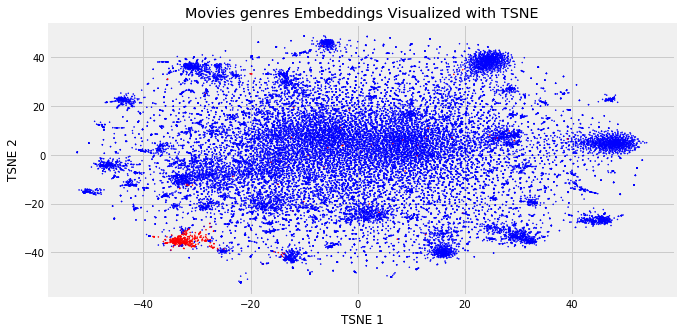

In [59]:
# Build a test vector for the 'short' keyword
test_short = genres_kw_df.apply(isgenre, args=('short',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_short.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Trying to identify what is the large MIDDLE cluster

In [60]:
ids_middle_cluster = np.where((tsne_test[:, 0] < 0) & (tsne_test[:, 0] > -5) & (tsne_test[:, 1] > 20) & (tsne_test[:, 1] < 30))[0]
genres_kw_df.loc[ids_middle_cluster, ['title', 'genres', 'keywords']]

title  \
102                                             Dogville   
964                                                 Nell   
1198                                         Preludio 11   
1210                                      Sonntagsfahrer   
1318                                     Special Killers   
1449                                              Postal   
1804                        The Puzzle of the Red Orchid   
1838                 Heldentod - Der Tunnel und die Lüge   
2087                                      Risky Business   
2125                                    Jean de Florette   
2126                                 Manon of the Spring   
2320                                Chicken with Vinegar   
2564                                     Finders Keepers   
2565                                     Finders Keepers   
2639                                     Where's Willie?   
2685                                   Inn of the Damned   
2822                                          The Pledge   
2951                                          Cat People   
3030                                            The Jerk   
3188                              No Country for Old Men   
3351                              The Road to Guantanamo   
3389             The Three Burials of Melquiades Estrada   
3409                                              Tuvalu   
3582                                          Borderline   
3910                                             Witness   
4113                                    Anger Management   
4246                                           Hard Luck   
4404                                               Haven   
4477                                         Funny Money   
4529                          Walking Tall: Lone Justice   
...                                                  ...   
24388                                       Hot Rod Girl   
24581                                       Tight Skin 2   
24583                                       Tight Skin 4   
24629                                          Company K   
24642                                    Hidden Assassin   
24952                                     Love's Brother   
25085                            One Summer of Happiness   
25107                             Atlas Shrugged: Part I   
25361                                          The Maker   
26038                     This World, Then the Fireworks   
26128                                             Lilith   
26443                                    Too Many Crooks   
26533                                     Johnny Belinda   
26601                                               Home   
27188                                   Sinfonía erótica   
27481                                       Housekeeping   
27536                                Manon of the Spring   
27937                             Filmmakers vs. Tycoons   
28088  Come Back to the 5 & Dime, Jimmy Dean, Jimmy Dean   
28186                               Filmmakers in Action   
28256                                           The Pipe   
28487                                       Beastie Boys   
28747                                        Soft Places   
28939                                         Jitterbugs   
29098                         The Guns Of Fort Petticoat   
29267                                    Private Lessons   
29290                                         Loan Shark   
29311                                        Doctor Bull   
29471                                      Claustrofobia   
29631                                                Why   

                                          genres  \
102                         crime,drama,thriller   
964                               drama,thriller   
1198                                   war,drama   
1210                                       drama   
1318                                       crime   
1449              

Looks like war movies. But with lots of keywords making the clustering more difficult

Now check our hypothesis : let's identify the war movies

In [61]:
# Build a test vector for the 'war' keyword
test_war = genres_kw_df.apply(isgenre, args=('war',), axis=1)

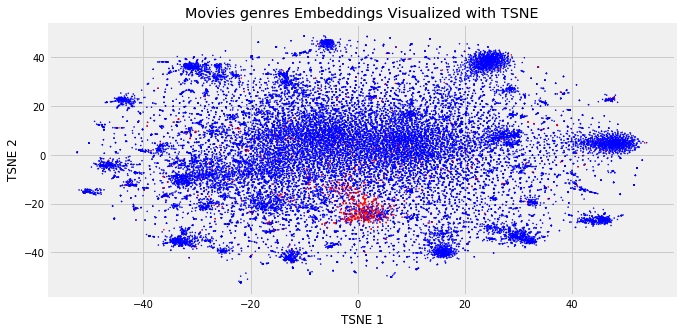

In [62]:
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_war.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

This is why this cluster is more spread, the war movies do not land exactly where we were looking at. Those movies are defined by more than one keyword

Is there a independent film-related movies cluster ?

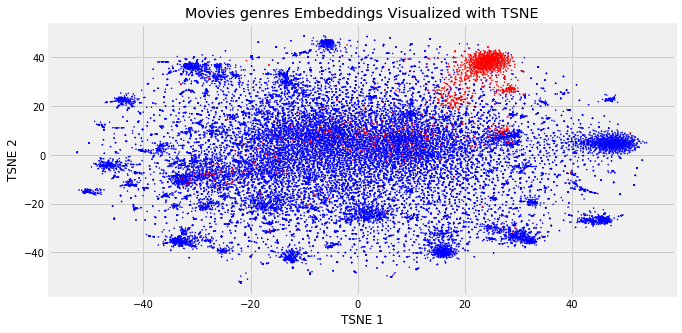

In [63]:
# Build a test vector for the 'independent film' keyword
test_independent = genres_kw_df.apply(isgenre, args=('independent film',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_independent.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Is there a music-related movies cluster ?

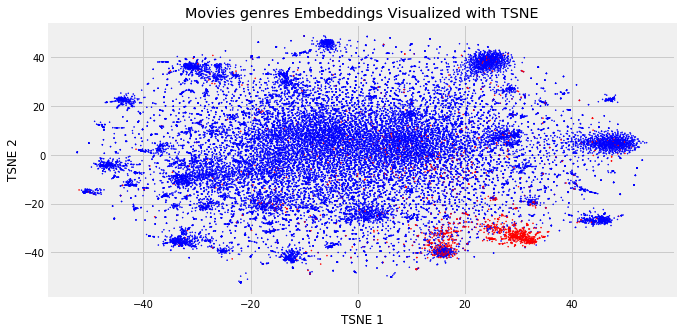

In [64]:
# Build a test vector for the 'music' keyword
test_music = genres_kw_df.apply(isgenre, args=('music',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_music.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Is there a suspense-related movies cluster ?

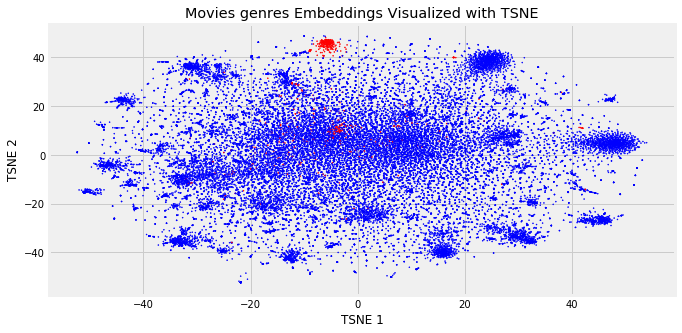

In [65]:
# Build a test vector for the 'suspense' keyword
test_suspense = genres_kw_df.apply(isgenre, args=('suspense',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_suspense.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

Is there a western-related movies cluster ?

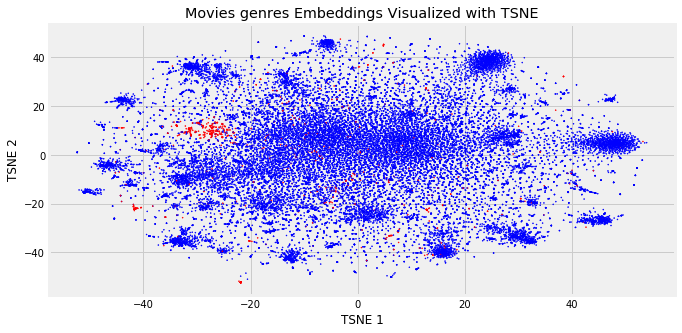

In [66]:
# Build a test vector for the 'western' keyword
test_western = genres_kw_df.apply(isgenre, args=('western',), axis=1)
# Plot
plt.figure(figsize = (10, 5))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=cmap_2c(norm_2c(test_western.values)), s=1)
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Movies genres Embeddings Visualized with TSNE');

## Try to color the mapping with most common keywords

Building keywords counts

In [67]:
# Gather all keywords from all movies
movies_keywords = genres_kw_df.kw_list.values.tolist()
movies_keywords_list = [inner for outer in movies_keywords for inner in outer]
# Count occurences
val, counts = np.unique(np.array(movies_keywords_list), return_counts=True)
# Create array for best import to dataframe
count_array = np.hstack([val.reshape(-1,1), counts.reshape(-1,1)])
# Create dataframe
kw_count_df = pd.DataFrame(count_array, columns=['kw', 'count'])
kw_count_df.loc[:, 'count'] = kw_count_df.loc[:, 'count'].astype(int)
kw_count_df = kw_count_df.sort_values('count', ascending=False)
kw_count_df.head(20)

kw  count
17357             woman director   2106
7885            independent film   2030
10431                     murder   1263
1228      based on novel or book    981
10491                    musical    890
14031                        sex    726
14874                      sport    660
15452                   suspense    649
16865                   violence    615
13116                    revenge    586
9242                        love    510
14229                      short    465
11975                     police    437
11459  parent child relationship    425
5805                   film noir    422
17440               world war ii    421
13987                     sequel    404
1523                   biography    403
3372                     concert    399
9618                martial arts    378

A few keywords are frequent, most are rare

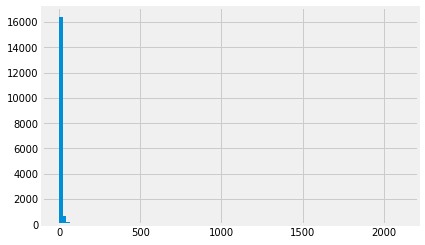

In [68]:
kw_count_df.loc[:, 'count'].hist(bins=100);

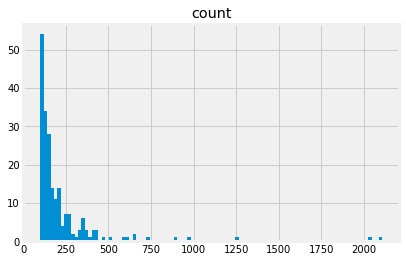

In [69]:
kw_count_df[kw_count_df.loc[:, 'count'] > 100].hist(bins=100);

Get 19 most common keywords

In [70]:
index_most_common_kw = {kw : idw for idw, kw in enumerate(kw_count_df.head(19).kw.values.tolist())}
index_most_common_kw['other'] = 19
index_most_common_kw

{'woman director': 0,
 'independent film': 1,
 'murder': 2,
 'based on novel or book': 3,
 'musical': 4,
 'sex': 5,
 'sport': 6,
 'suspense': 7,
 'violence': 8,
 'revenge': 9,
 'love': 10,
 'short': 11,
 'police': 12,
 'parent child relationship': 13,
 'film noir': 14,
 'world war ii': 15,
 'sequel': 16,
 'biography': 17,
 'concert': 18,
 'other': 19}

In [71]:
def input_color(kw_list, target, value):
    if target in kw_list:
        return value
    else:
        return 19

In [72]:
movies_genres_kw_df = genres_kw_df.loc[:, ['title', 'genres_list', 'kw_list']]
for kw, value in index_most_common_kw.items():
    movies_genres_kw_df.loc[:, kw] = genres_kw_df.kw_list.apply(input_color, args=(kw, value))

In [73]:
def select_color(row):
    if (row == 19).astype(int).sum() != 20:
        return row[row != 19].values[0]
    else:
        return 19
movies_genres_kw_df.loc[:, 'colors'] = movies_genres_kw_df.iloc[:, 3:].apply(select_color, axis=1)
movies_genres_kw_df.loc[:, 'sizes'] = movies_genres_kw_df.colors.apply(lambda x: 1 if x == 19 else 10)

In [120]:
movies_common_kw_sample = {}
for kw, color in index_most_common_kw.items():
    movie_color_sample = movies_genres_kw_df.loc[:, 'colors'][movies_genres_kw_df.loc[:, 'colors'] == color]
    tsne_coordinates = tsne_test[movie_color_sample.index.values]
    movies_common_kw_sample[kw] = np.percentile(tsne_coordinates, 50, axis=0)

While we plot the result we label the 19 most common keywords from the median of the coordinates of the movies related to those popular keywords, which is therefore approximation but precise-enough to label most obvious clusters

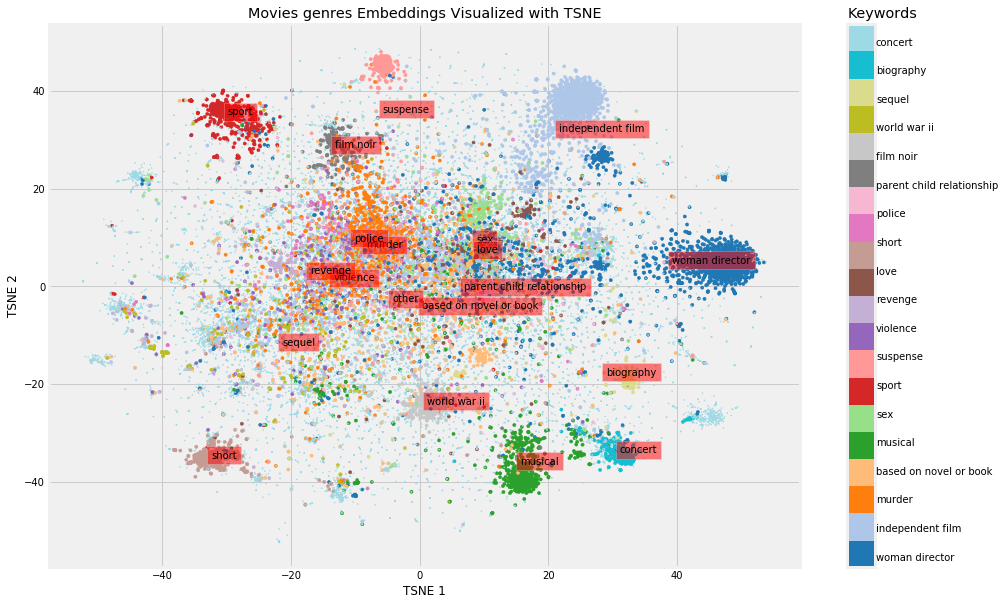

In [121]:
# Plot
plt.figure(figsize = (15, 10))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=movies_genres_kw_df.colors, cmap=cm.get_cmap('tab20'), s=movies_genres_kw_df.sizes)
ax = plt.gca()
ax.set_xlabel('TSNE 1');
ax.set_ylabel('TSNE 2');
ax.set_title('Movies genres Embeddings Visualized with TSNE')
# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(list(index_most_common_kw.keys())[:-1]):
    cbar.ax.text(20, 0.25 + j, lab)
cbar.ax.set_title('Keywords', loc = 'left')
for kw, (x, y) in movies_common_kw_sample.items():
    plt.text(s=kw, x=x, y=y, bbox=dict(facecolor='red', alpha=0.5));

Again we see that movies that are mostly defined by a unique keyword are brought together in the TSNE visualisation. Nevertheless movies defined by more than one keyword are tougher to get close to one another.

# 9) Testing plan

We aim to test our recommender system with the following:

- 1) 100 movies of 'drama' type
- 2) 100 movies of 'comedy' type
- 3) 100 movies of 'drama' type and another type
- 4) 100 movies of 'comedy' type and another type
- 5) 100 movies of 'drama' type and two others type
- 6) 100 movies of 'comedy' type and two others type
- 7) 100 movies with the 'woman director' keyword (most common)
- 8) 100 movies with the 'revenge' keyword (quite common)
- 9) 100 movies with the 'robot' keyword (less common, only 102 occurences)
- 10) 20 movies with the 'skyscraper' keyword (rare, only 20 occurences)

**The plotting may be boring and I recommend to the reader to jump to conclusion of this chapter 9)**

In [76]:
drama_movies = genres_kw_df[genres_kw_df.genres == 'drama'].sample(100, random_state=0)
comedy_movies = genres_kw_df[genres_kw_df.genres == 'comedy'].sample(100, random_state=0)
drama2_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 2) and ('drama' in x) else False)
drama2_movies = genres_kw_df.loc[drama2_ind, :].sample(100, random_state=0)
comedy2_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 2) and ('comedy' in x) else False)
comedy2_movies = genres_kw_df.loc[comedy2_ind, :].sample(100, random_state=0)
drama3_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 3) and ('drama' in x) else False)
drama3_movies = genres_kw_df.loc[drama3_ind, :].sample(100, random_state=0)
comedy3_ind = genres_kw_df.genres_list.apply(lambda x: True if (len(x) == 3) and ('comedy' in x) else False)
comedy3_movies = genres_kw_df.loc[comedy3_ind, :].sample(100, random_state=0)

In [77]:
woman_director_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('woman director')].sample(100, random_state=0)
revenge_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('revenge')].sample(100, random_state=0)
robot_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('robot')].sample(100, random_state=0)
skyscraper_movies = genres_kw_df[genres_kw_df['keywords'].str.contains('skyscraper')].sample(20, random_state=0)

In [193]:
dramas_genres_ac = []
dramas_kw_ac = []
comedy_genres_ac = []
comedy_kw_ac = []
keywords_genres_ac = []
keywords_kw_ac = []

### 9.1) Drama movies test

Movie 100 / 100

Genres accuracy : 0.33
Keywords accuracy : 0.32


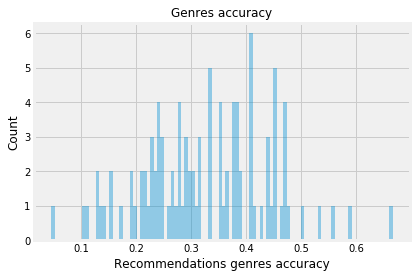

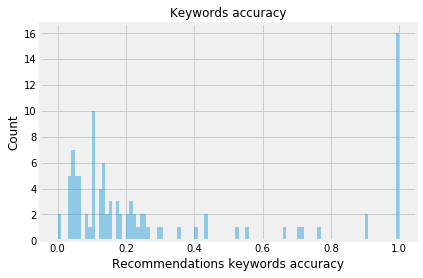

In [194]:
gac, kwac = recommender_behaviour_study(drama_movies, genres_kw_df)   
dramas_genres_ac.append(gac)
dramas_kw_ac.append(kwac)

### 9.2) Comedy movies test

Movie 100 / 100

Genres accuracy : 0.33
Keywords accuracy : 0.39


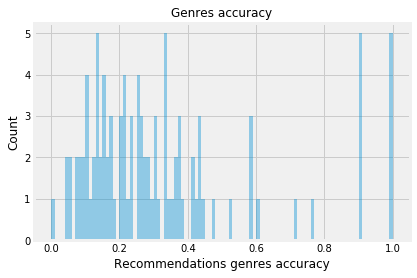

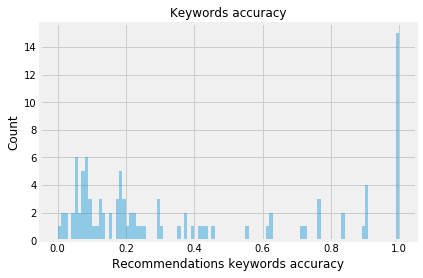

In [195]:
gac, kwac = recommender_behaviour_study(comedy_movies, genres_kw_df)
comedy_genres_ac.append(gac)
comedy_kw_ac.append(kwac)

### 9.3) Drama + another genre movies test

Movie 100 / 100

Genres accuracy : 0.43
Keywords accuracy : 0.21


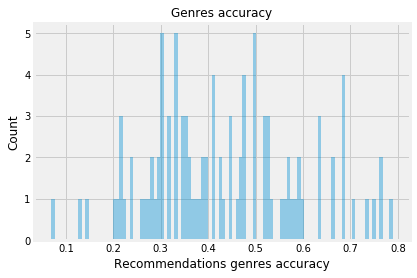

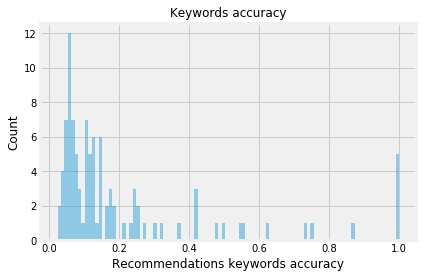

In [196]:
gac, kwac = recommender_behaviour_study(drama2_movies, genres_kw_df)
dramas_genres_ac.append(gac)
dramas_kw_ac.append(kwac)

### 9.4) Comedy  + another genre movies test

Movie 100 / 100

Genres accuracy : 0.39
Keywords accuracy : 0.31


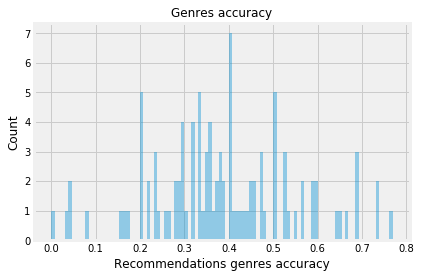

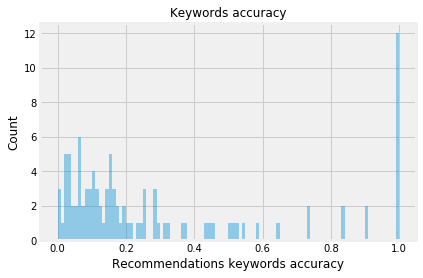

In [197]:
gac, kwac = recommender_behaviour_study(comedy2_movies, genres_kw_df)
comedy_genres_ac.append(gac)
comedy_kw_ac.append(kwac)

### 9.5) Drama + 2 others genres movies test

Movie 100 / 100

Genres accuracy : 0.51
Keywords accuracy : 0.22


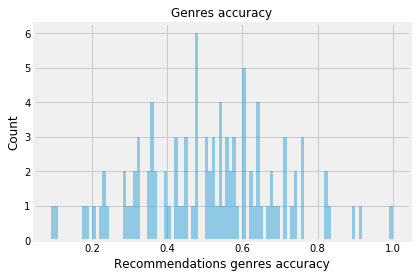

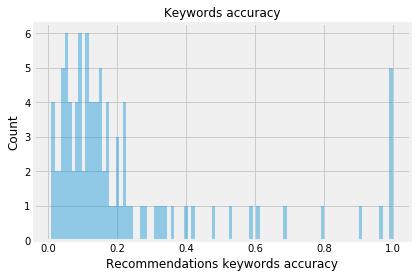

In [198]:
gac, kwac = recommender_behaviour_study(drama3_movies, genres_kw_df)
dramas_genres_ac.append(gac)
dramas_kw_ac.append(kwac)

### 9.6) Comedy + 2 others genres movies test

Movie 100 / 100

Genres accuracy : 0.51
Keywords accuracy : 0.28


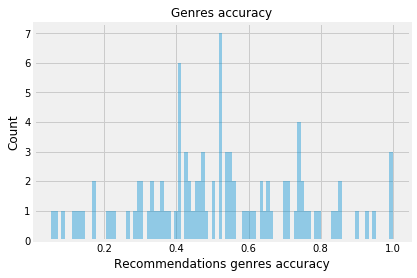

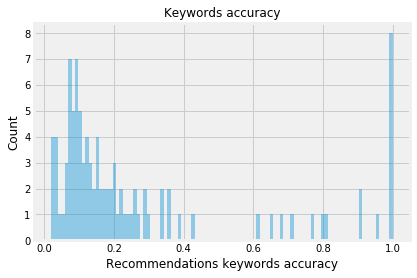

In [199]:
gac, kwac = recommender_behaviour_study(comedy3_movies, genres_kw_df)
comedy_genres_ac.append(gac)
comedy_kw_ac.append(kwac)

### 9.7) woman director movies test

Movie 100 / 100

Genres accuracy : 0.44
Keywords accuracy : 0.57


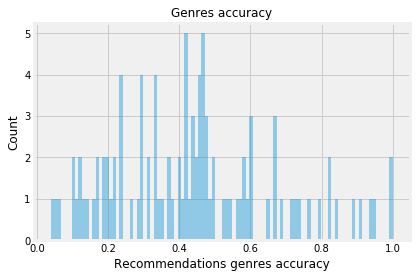

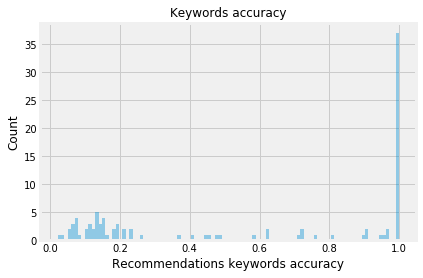

In [200]:
gac, kwac = recommender_behaviour_study(woman_director_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.8) revenge movies test

Movie 100 / 100

Genres accuracy : 0.42
Keywords accuracy : 0.15


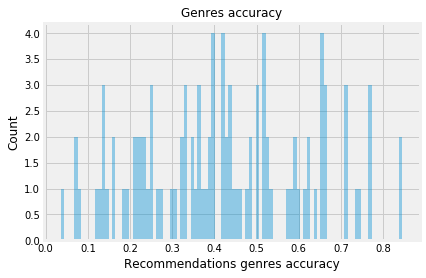

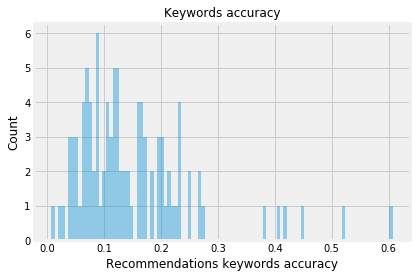

In [201]:
gac, kwac = recommender_behaviour_study(revenge_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.9) robot movies test

Movie 100 / 100

Genres accuracy : 0.45
Keywords accuracy : 0.17


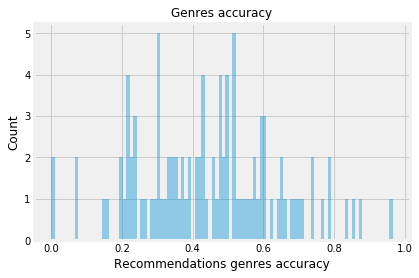

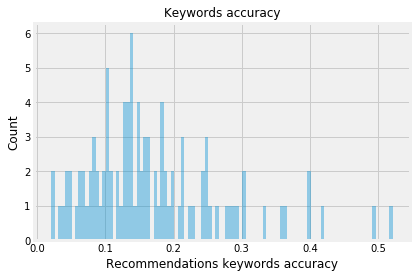

In [202]:
gac, kwac = recommender_behaviour_study(robot_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.10) skyscraper movies test

Movie 20 / 20

Genres accuracy : 0.45
Keywords accuracy : 0.14


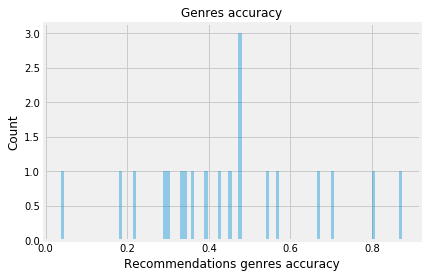

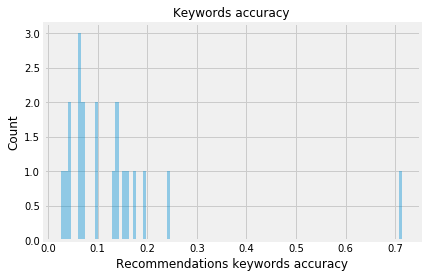

In [203]:
gac, kwac = recommender_behaviour_study(skyscraper_movies, genres_kw_df)
keywords_genres_ac.append(gac)
keywords_kw_ac.append(kwac)

### 9.11) Conclusion : Influence of multiple genres and keyword frequency on recommendations

As we did not try lots of combinations, this can be named 'conclusion' but should more be considered as 'first idea of what is going on here'

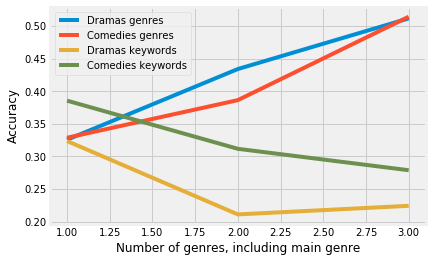

In [211]:
n_genres = [1, 2, 3]
plt.plot(n_genres, dramas_genres_ac, label='Dramas genres')
plt.plot(n_genres, comedy_genres_ac, label='Comedies genres')
plt.plot(n_genres, dramas_kw_ac, label='Dramas keywords')
plt.plot(n_genres, comedy_kw_ac, label='Comedies keywords')
ax = plt.gca()
ax.set_xlabel("Number of genres, including main genre")
ax.set_ylabel("Accuracy")
ax.legend();

#### Two observations :

- 1) The **more we dilute** our main genre with others, the **more genre-similarity** we observe in recommendations
- 2) The **more we dilute** our main genre with others, the **less keywords-similarity** we observe in recommendations

This makes sense with our keywords-trained model. A genre is more likely to be related to a certain set of keywords, a lexical field of the genre. Therefore if we add more genres to the lookup, we add more keywords to find and our keywords-oriented recommender is having more difficulties to predict the accurate keywords. This behaviour may be related to our database being small.

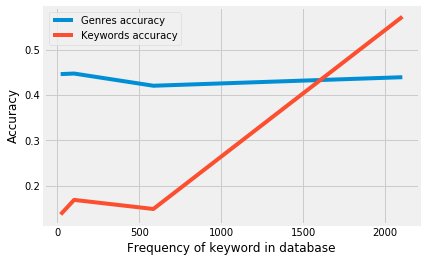

In [212]:
kw_freq = kw_count_df.loc[:, 'count'][kw_count_df.kw.isin(['woman director', 'revenge', 'robot', 'skyscraper'])]
plt.plot(kw_freq, keywords_genres_ac, label='Genres accuracy')
plt.plot(kw_freq, keywords_kw_ac, label='Keywords accuracy')
ax = plt.gca()
ax.set_xlabel("Frequency of keyword in database")
ax.set_ylabel("Accuracy")
ax.legend();

#### Two observations :

- 1) The **more frequent** our main keyword is, the **more keywords-similarity** we observe in recommendations
- 2) The frequency of keywords does not seem to impact the genres accuracy of recommendations

This confirm even more that our model is keywords-oriented. Having issues finding movies showing keywords less represented in our database used to train the model.

# 10) Studying recommendations from embedding and nearest neighbors methods

In each of the 6 examples we study here, the nearest neighbor model trained on one-hot encoded strings of genres and keywords is actually not too bad in recommending movies with identic genres. It might not be shocking as the very sparse matrix will have more ones in the different genres strings columns than in the keywords strings columns, because there is less combinations of genres than there is of keywords.

However and as expected, this model is clueless about recommending keywords (accuracte recommendations may be lucky).

Our embedding model is acting the other way around, recommending from keywords and as a consequence, recommending accurate-enough genres.

## 1) Batman & Robin

In [140]:
movie_ref = 'Batman & Robin'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['Mission: Impossible II', 'Spider-Man 3', 'Open Your Eyes', 'Olympia Part Two: Festival of Beauty', 'One Million B.C.']
recom_emb = ['Superman II', "The Batman Superman Movie: World's Finest", 'Justice League: The New Frontier', 'All Star Superman', 'Batman: Under the Red Hood']
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 1.1) Nearest neighbors

Genres accuracy : 0.36


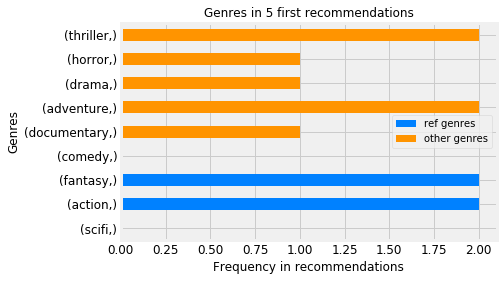

In [141]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.03


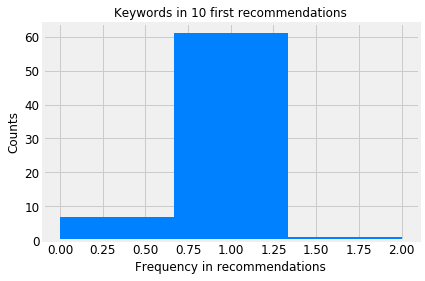

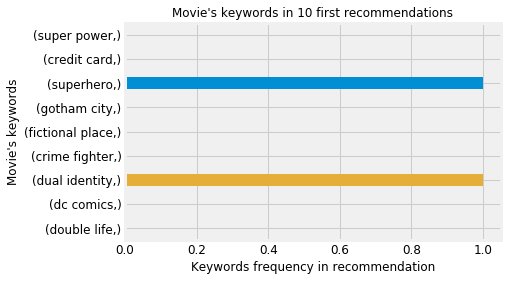

In [142]:
recom_kw_study(movie_ref, recom_nn_df)

### 1.2) Word embedding

Genres accuracy : 0.47


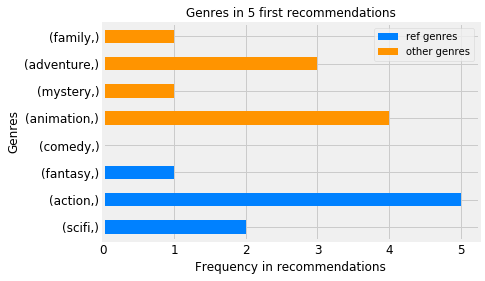

In [143]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.38


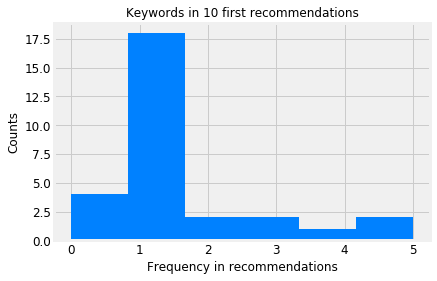

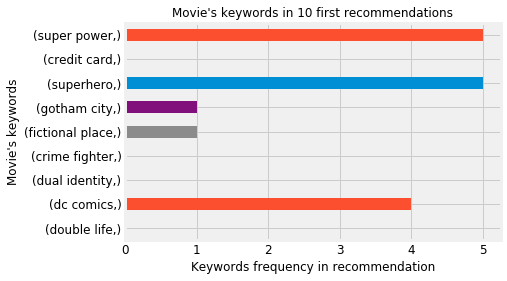

In [144]:
recom_kw_study(movie_ref, recom_emb_df)

## 2) X-Men

In [145]:
movie_ref = 'X-Men'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['Return of the Jedi', 'Journey 2: The Mysterious Island', 'Gamera vs. Viras', 'Ra.One', 'The Empire Strikes Back']
recom_emb = ['X-Men: The Last Stand', 'X2', 'Justice League: The New Frontier', 'Hulk vs. Wolverine', 'Generation X']
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 2.1) Nearest neighbors

Genres accuracy : 1.00


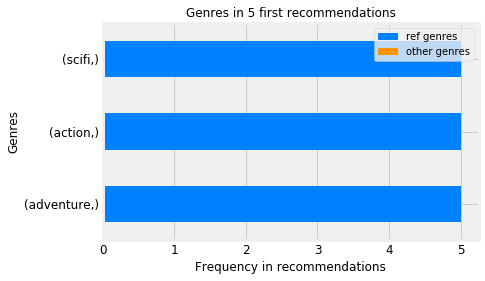

In [146]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.02


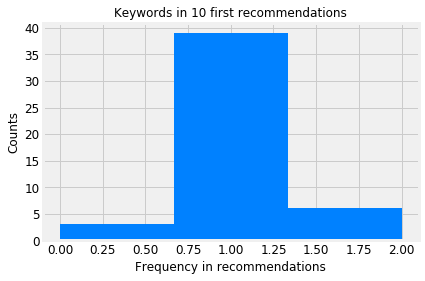

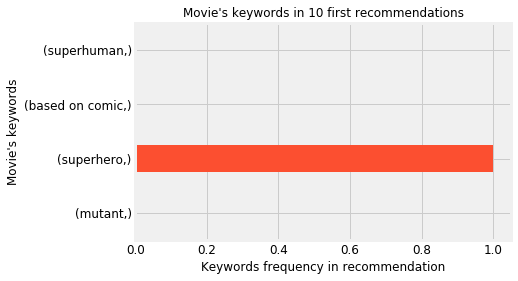

In [147]:
recom_kw_study(movie_ref, recom_nn_df)

### 2.2) Word embedding

Genres accuracy : 0.64


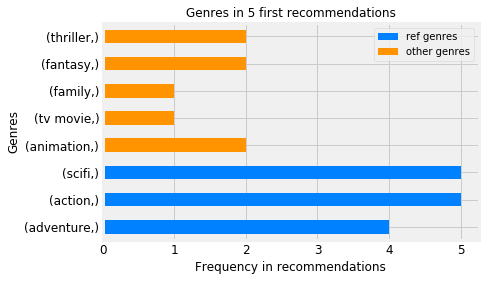

In [148]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.60


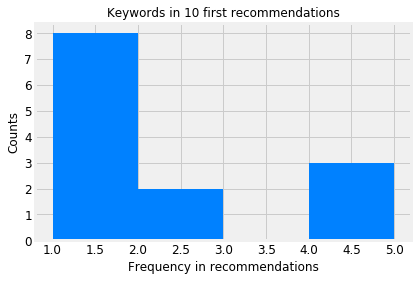

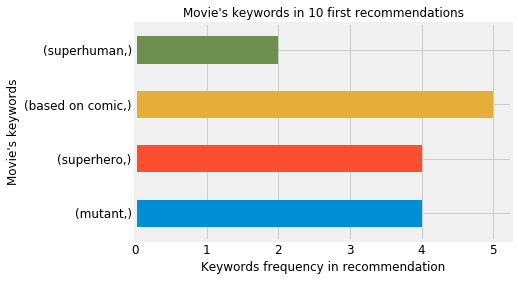

In [149]:
recom_kw_study(movie_ref, recom_emb_df)

## 3) Stargate

In [150]:
movie_ref = 'Stargate'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = [' Captain America: The First Avenger', 'Independence Day', 'Total Recall', 'Tycus', 'King Kong vs. Godzilla']
recom_emb = ['The Right Stuff', 'The Angry Red Planet', 'Tobor the Great', 'Avatar', 'Stargate: The Ark of Truth']
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 3.1) Nearest neighbors

Genres accuracy : 0.94


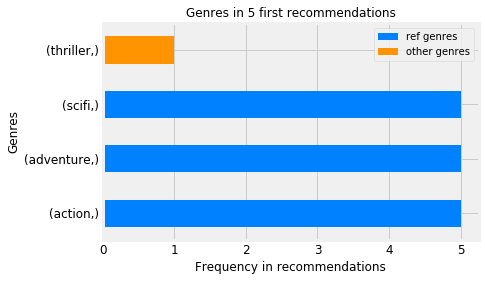

In [151]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.00


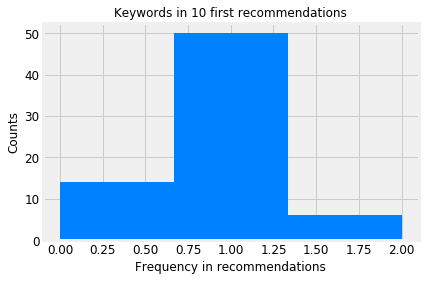

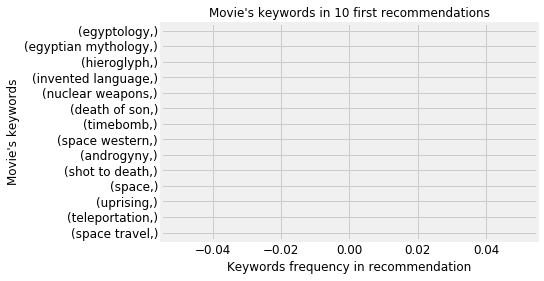

In [152]:
recom_kw_study(movie_ref, recom_nn_df)

### 3.2) Word embedding

Genres accuracy : 0.67


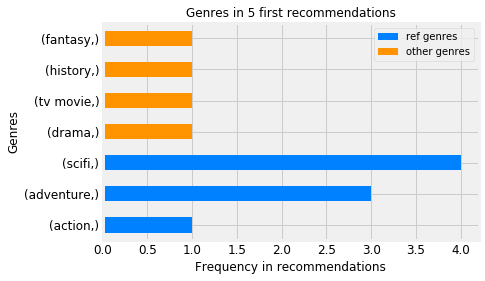

In [153]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.11


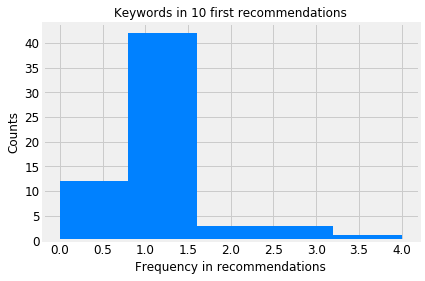

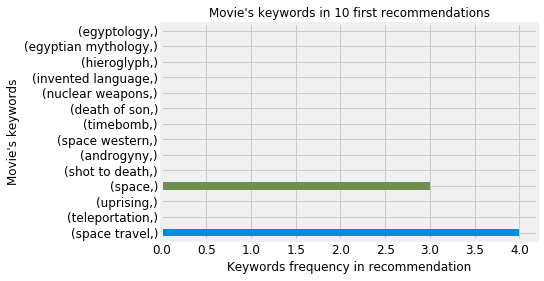

In [154]:
recom_kw_study(movie_ref, recom_emb_df)

## 4) The Good, the Bad and the Ugly 

In [155]:
movie_ref = 'The Good, the Bad and the Ugly'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['The Magnificent Seven', 'For a Few Dollars More', 'Tension at Table Rock', 'Open Range', 'Heaven with a Gun']
recom_emb = ['Death Rides a Horse', 'R.I.P.D.', 'The Great Silence', 'Young Guns II', 'Sniper 2']
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 4.1) Nearest neighbors

Genres accuracy : 1.00


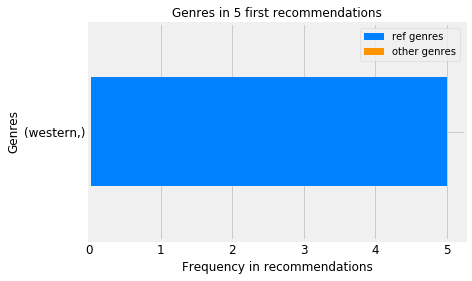

In [156]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.06


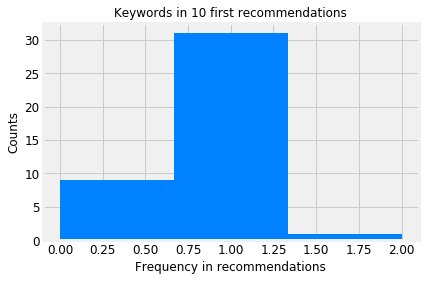

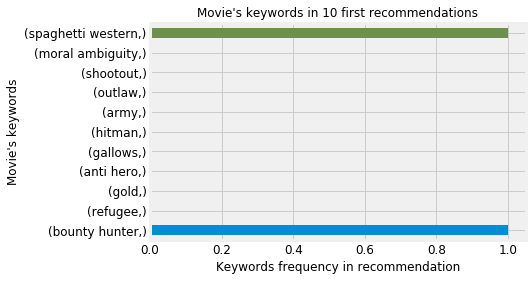

In [157]:
recom_kw_study(movie_ref, recom_nn_df)

### 4.2) Word embedding

Genres accuracy : 0.33


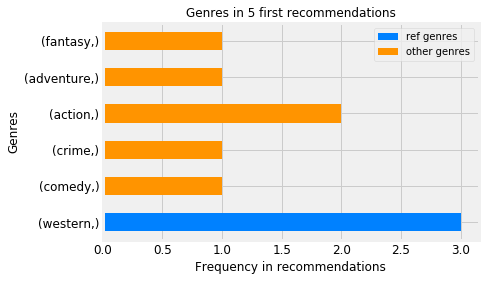

In [158]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.08


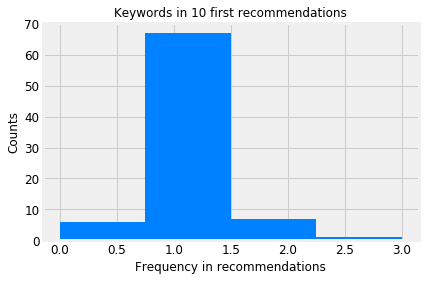

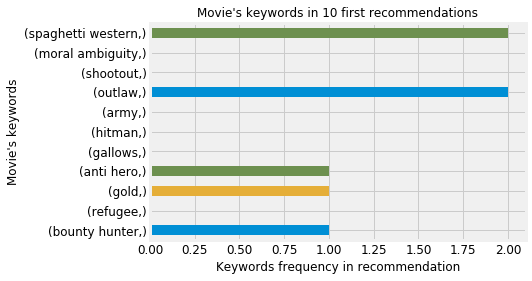

In [159]:
recom_kw_study(movie_ref, recom_emb_df)

## 5) Love Actually

In [160]:
movie_ref = 'Love Actually'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = ['Leatherheads', 'When Harry Met Sally...', 'Roman Holiday', "Bridget Jones's Diary", 'No Reservations']
recom_emb = ['Jack & Sarah', 'Reign Over Me', 'The Holiday', '8 Women', "Bridget Jones's Diary"]
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 5.1) Nearest neighbors

Genres accuracy : 1.00


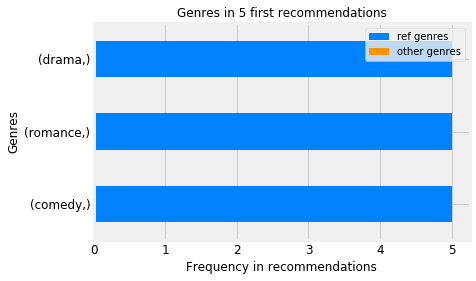

In [161]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.05


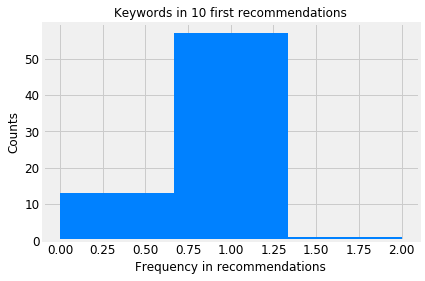

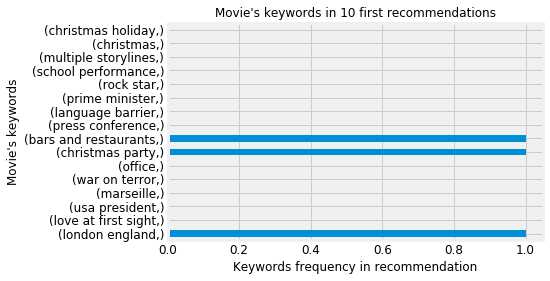

In [162]:
recom_kw_study(movie_ref, recom_nn_df)

### 5.2) Word embedding

Genres accuracy : 0.71


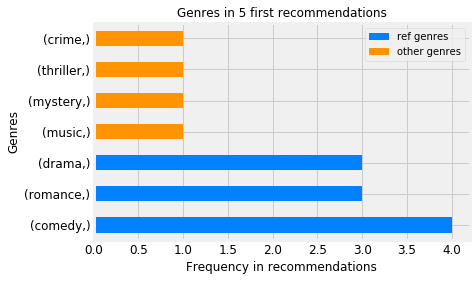

In [163]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.15


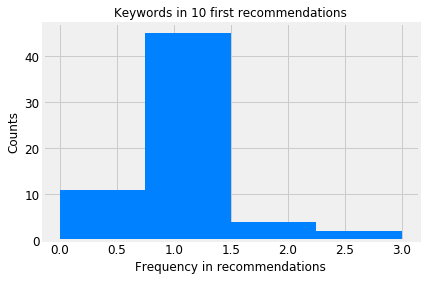

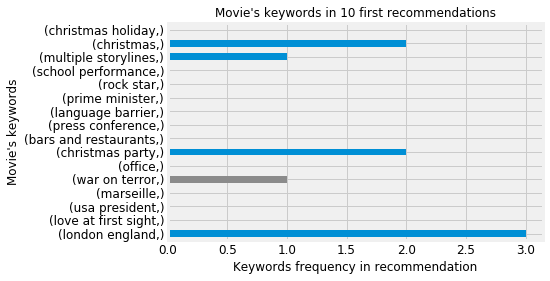

In [164]:
recom_kw_study(movie_ref, recom_emb_df)

## 6) Pearl Harbor

In [165]:
movie_ref = 'Pearl Harbor'
idx_movie_ref = genres_kw_df[genres_kw_df.title == movie_ref].index[0]
movie_ref = genres_kw_df.loc[idx_movie_ref, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_nn = [' Un Chien Andalou', 'A Fish Called Wanda', 'Trainspotting', 'The Killing Fields', 'Interview with the Vampire']
recom_emb = ['Seven Beauties', 'Valkyrie', 'Paths of Glory', 'The Dirty Dozen: Next Mission', 'Sole Survivor']
recom_nn_df = genres_kw_df[genres_kw_df.title.isin(recom_nn)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]
recom_emb_df = genres_kw_df[genres_kw_df.title.isin(recom_emb)].loc[:, ['title', 'genres', 'keywords', 'genres_list', 'kw_list']]

### 6.1) Nearest neighbors

Genres accuracy : 0.50


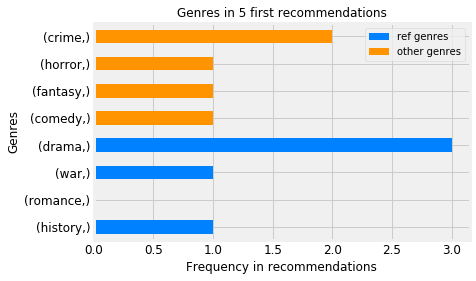

In [166]:
recom_genres_study(movie_ref, recom_nn_df)

Keywords accuracy : 0.00


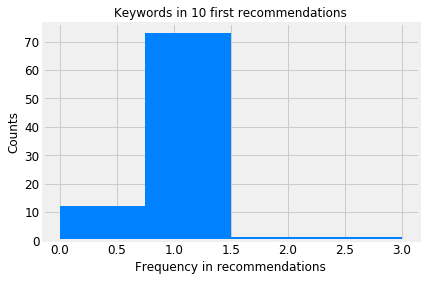

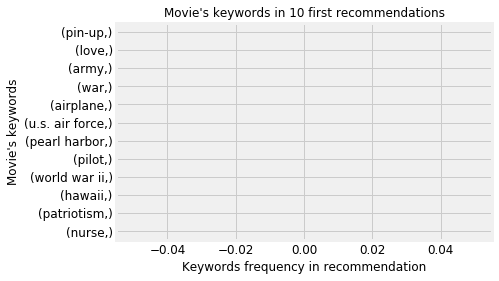

In [167]:
recom_kw_study(movie_ref, recom_nn_df)

### 6.2) Word embedding

Genres accuracy : 0.50


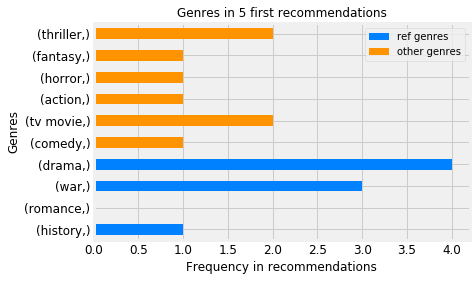

In [168]:
recom_genres_study(movie_ref, recom_emb_df)

Keywords accuracy : 0.17


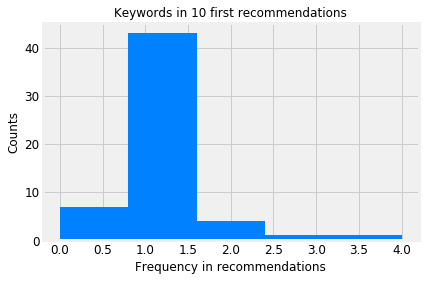

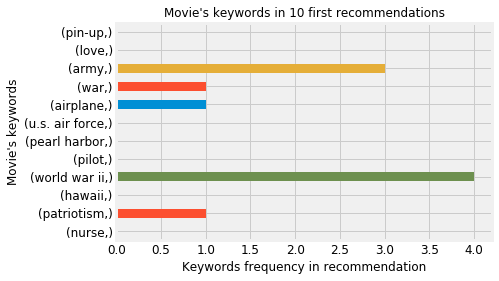

In [169]:
recom_kw_study(movie_ref, recom_emb_df)